In [2]:
import base64
import datetime
import json
import os
import pickle
import re
import time

import emoji
import nltk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

from collections import Counter
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

In [19]:
# Download required nltk packages and set Pandas options
nltk.download()

pd.set_option('display.max_colwidth', None)

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


# Configuration

Setup the Twitter API configuration and Twitter Search API parameters for fetching the datasets.

In [19]:
# Setup Twitter API configuration
client_key = 'k7IeaeoVVSVVRs2VMRyjWMGhB'
client_secret = 'QjWhmf3ylIKXTYn6zv26tTkPjobjbapTKlC4JDay74jd647mcl'
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAO3%2BQgEAAAAAKO%2BcZLOP%2B1jh1SeWDdIMpCF4smc%3DiUFDhj7SZfb1fl177n5Fipd9OA2Elj9aVdezk2hhBUGbTrdLgY'

key_secret = '{}:{}'.format(client_key, client_secret).encode('ascii')
b64_encoded_key = base64.b64encode(key_secret)
b64_encoded_key = b64_encoded_key.decode('ascii')

base_url = 'https://api.twitter.com/'
auth_endpoint = base_url + 'oauth2/token'

auth_headers = { 
	'Authorization': 'Basic {}'.format(b64_encoded_key),
	'Content-Type': 'application/x-www-form-urlencoded;charset=UTF-8' }

auth_data = { 'grant_type': 'client_credentials' }

# Get access token
response = requests.post(auth_endpoint, headers=auth_headers, data=auth_data)
json_data =  response.json()
access_token = json_data['access_token']

In [45]:
# Setup the queries and base parameters to execute to seed data
queries = {
	'basketball': '#olympics basketball -is:retweet lang:en',
	'biking': '#olympics biking -is:retweet lang:en',
	'diving': '#olympics diving -is:retweet lang:en',
	'gymnastics': '#olympics gymnastics -is:retweet lang:en',
	'skateboard': '#olympics skateboard -is:retweet lang:en',
	'surfing': '#olympics surfing -is:retweet lang:en',
	'track': '#olympics track -is:retweet lang:en',
	'volleyball': '#olympics volleyball -is:retweet lang:en',
}

max_tweets = 5000
tweet_limit = 100

search_url = base_url + '2/tweets/search/recent'

# Data Request
Determine if the pickled output exists and re-request the Twitter data if it does not.

In [21]:
# Define a method for obtaining tweet data
def get_tweets(access_token, query, max_tweets=10, tweet_limit=10):
	"""Retrieve tweets from the recent search API.
	Args
	----
		access_token (str): A valid bearer token for making Twitter API requests.
		query (str): A valid Twitter query string for filtering the search tweets.
		max_tweets (int): The maximum number of tweets to collect in total.
		tweet_limit (int): The number of maximum tweets per API request. 
    """

	page_token = None
	tweet_data = []

	search_headers = { 'Authorization': 'Bearer {}'.format(access_token), 'User-Agent': 'v2FullArchiveSearchPython'}


	# Divides the max tweets into the appropriate number of requests based on the tweet_limit.
	for i in range(max_tweets // tweet_limit - 1):
		search_parameters = {
			'query': query,
			'max_results': tweet_limit,
			'tweet.fields': 'created_at,conversation_id'
		}
		# print(f'\tRequest {i + 1}: {query}')
		
		# If we reach the 2nd page of results, add a next_token attribute to the search parameters
		if i > 0: 
			search_parameters['next_token'] = page_token

		response = requests.get(search_url, headers=search_headers, params=search_parameters)
		if response.status_code != 200:
			print(f'\tError occurred: Status Code{response.status_code}: {response.text}')
		else:
			# We need to check for a result count before doing anything futher; if we have result_count we have data
			if response.json()['meta']['result_count'] > 0:
				tweet_data.extend(response.json()['data'])
				
				# If a 'next_token' exists, then update the page token to continue pagination through results
				if 'next_token' in response.json()['meta']:
					page_token = response.json()['meta']['next_token']
			else:
				print(f'\tNo data returned for query!')
				break
		print(f'\t[{len(tweet_data)}] results collected')
		time.sleep(1) # pause in between requests per twitter robots.txt
	return tweet_data

In [22]:
get_path = lambda name: './data/' + name + '-tweets.pkl' # store filenaming syntax

# Check if we need to re-process any data, serialize it, and store it
for (k, v) in queries.items():
	if not os.path.exists(get_path(k)):
		print(f'Processing {k}')
		tweet_data = get_tweets(access_token, v, max_tweets, tweet_limit)
		if tweet_data:
			with open(get_path(k), 'wb') as f:
				pickle.dump(tweet_data, f)
				print(f'Tweet data for {k} dumped to .pkl')
	else:
		print(f'Dataset already exists for {get_path(k)}!')
print('Finished data requesting')

Dataset already exists for ./data/basketball-tweets.pkl!
Dataset already exists for ./data/diving-tweets.pkl!
Dataset already exists for ./data/gymnastics-tweets.pkl!
Dataset already exists for ./data/skateboard-tweets.pkl!
Dataset already exists for ./data/surfing-tweets.pkl!
Dataset already exists for ./data/track-tweets.pkl!
Dataset already exists for ./data/volleyball-tweets.pkl!
Finished data requesting


# De-Serialize & Clean Data

Read the cached tweet data from the serialized pickle files and store into corresponding dataframes. 

## Data Preparation

* Remove duplicate tweets
* Convert data types
* Handle NaN values

In [53]:
# Deserialize all of the datasets into a single dataset
olympic_df = pd.DataFrame(columns=['id', 'created_at', 'conversation_id', 'text'])

for s in queries.keys():
	print(f'Deserializing {s}')
	df = pd.DataFrame(pd.read_pickle('./data/' + s + '-tweets.pkl'))
	df['sport'] = s
	olympic_df = olympic_df.append(df, ignore_index=True)

olympic_df.shape

Deserializing basketball
Deserializing biking
Deserializing diving
Deserializing gymnastics
Deserializing skateboard
Deserializing surfing
Deserializing track
Deserializing volleyball


(30554, 6)

In [54]:
olympic_df.dtypes

id                 object
created_at         object
conversation_id    object
text               object
sport              object
withheld           object
dtype: object

In [55]:
# Convert data types
olympic_df.id = olympic_df.id.astype('int32')
olympic_df.created_at = pd.to_datetime(olympic_df.created_at)
olympic_df.conversation_id = olympic_df.conversation_id.astype('int32')
olympic_df.drop(['withheld'], axis=1, inplace=True) # drop the unnecessary withheld column
olympic_df.dtypes

id                               int32
created_at         datetime64[ns, UTC]
conversation_id                  int32
text                            object
sport                           object
dtype: object

In [56]:
# Drop duplicates prior to any processing
olympic_df.drop_duplicates(inplace=True)
olympic_df.shape

(23330, 5)

In [57]:
olympic_df.isna().sum()

id                 0
created_at         0
conversation_id    0
text               0
sport              0
dtype: int64

## Data Cleansing
* Remove puncutation
* Remove user mentions
* Remove hashtags
* Remove URLs

In [58]:
# Remove user mentions, hashtags, and urls from a text string.
stops = stopwords.words('english')
stop_words = Counter(stops)

def clean_tweet_text(text):
	"""Cleanses a tweet text of user mentions, links, hashtags, special characters, and emojis."""

	# Define any custom replacement pattern and join into an aggregated pattern
	replacements = [
		r'(@[\w]+)',
		r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
		r'(#\w+)',
		r'[\$&+,:;=?@#|\'<>.^*()%!-/]',
		r'\n',
		r'[0-9]+'
	]
	aggregate_pattern = r'|'.join(replacements)
	clean_text = re.sub(aggregate_pattern, '', text) # make regex substitutions in one pass
	
	# Return the unicode-stripped text in lowercase
	return clean_text.encode(encoding='ascii', errors='ignore').decode('ascii').lower()

# Make replacements
olympic_df['clean_text'] = olympic_df.text.apply(lambda row : clean_tweet_text(row))
olympic_df.sample(5)

id                created_at  conversation_id  \
3641     85291008 2021-08-07 04:32:30+00:00         85291008   
22125 -1059606526 2021-08-08 02:20:34+00:00      -1059606526   
17492 -1537798143 2021-08-08 11:53:58+00:00      -1537798143   
1449  -1999220736 2021-08-08 02:46:01+00:00         60231685   
5935   -686399487 2021-07-29 17:19:47+00:00                0   

                                                                                                                                                                                                                         text  \
3641                                                                    Team USA gets back at France to win for 4th straight Olympic hoops gold https://t.co/zRbMoUcifm | @mluisamorales_ @PhilstarNews #Olympics #Basketball   
22125                                                                                                                               India won its first gold in track and field and that man absolutely deserved it #Olympics   
17492  I still don’t understand how 13-year old kids can win skateboard medals at the Olympics. Surely 23-year olds with ten more years of training should be much better? Is there a good explanation? #Olympics #skateboard   
1449            @Chloeoe217 🏀🥇 Join us in an exclusive watch party to cheer team USA 🇺🇸 as they take on Japan 🇯🇵 in the Women’s Basketball Gold Medal match #Olympics #Tokyo2020 #Basketball #USABWNT https://t.co/31HGpd5xmk   
5935                                                                             And yet, that turned out to be surprisingly relatable! The difficulties of trying to cycle through dust clouds! (Be… https://t.co/oFtfW5iXEH   

            sport  \
3641   basketball   
22125       track   
17492  skateboard   
1449   basketball   
5935       biking   

                                                                                                                                                                                     clean_text  
3641                                                                                                               team usa gets back at france to win for th straight olympic hoops gold        
22125                                                                                                          india won its first gold in track and field and that man absolutely deserved it   
17492  i still dont understand how year old kids can win skateboard medals at the olympics surely year olds with ten more years of training should be much better is there a good explanation    
1449                                                               join us in an exclusive watch party to cheer team usa  as they take on japan  in the womens basketball gold medal match       
5935                                                                           and yet that turned out to be surprisingly relatable the difficulties of trying to cycle through dust clouds be

In [59]:
# Remove all stop words
olympic_df['clean_no_stops'] = olympic_df.clean_text.apply(lambda row: [ word.strip() for word in row.split() if word.strip() not in stop_words ])
olympic_df.sample(5)

id                created_at  conversation_id  \
427     -90877946 2021-08-08 08:34:32+00:00        -90877946   
22696 -1219125237 2021-08-07 14:05:48+00:00      -1219125237   
12492 -1554526206 2021-08-06 12:43:20+00:00      -1554526206   
28973  2056544258 2021-08-07 06:06:22+00:00       2056544258   
24843  -115974137 2021-08-06 14:01:25+00:00       -115974137   

                                                                                                                                                                                                                                                                                                                     text  \
427                                                                                 Hey @NBC, maybe showing Equestrian fifty million times on primetime while having basketball on your streaming app is part of the problem, no? No one gives a shit about equestrian! #Olympics\n#Tokyo2020 \n\nhttps://t.co/rqg7RAW5U1   
22696  @Neeraj_chopra1 Wins Gold🥇with a 87.58M Javelin Throw. Only the 2nd Indian to win Gold in an individual event, after 13years of #AbhinavBindra🎖️.\n1st Gold in Athletics track event .\n7th medal for #teamIndia at our most in the #Olympics history.\nThank you #NeerajChopra #Tokyo2020 https://t.co/MP1DDUqJFZ   
12492                                                                                                                                We’ve had such a busy morning at #eastlake joing in with sporting activities and doing some brain teasers #Olympics #diving #sports #crosswords #brainteaser https://t.co/sY7uVZaKe2   
28973                                                                              Brazil was playing catch up at the onset of set 3 but turned the tables and took the set 25-20!\n\nWill Argentina extend the match to set 5, or will Brazil take the 4th and the Bronze medal?\n\n#olympics \n#Tokyo2020 \n#Volleyball   
24843                                                 There's so much depth in our women's track team that any one of those women could have anchored.\n\nBut that's not the assignment. It's which combo will bring the best results.\n\nWe #Brawling #Jamaica #Olympics #Tokyo2020\n🇯🇲🖤🇯🇲💚🇯🇲💛🇯🇲 https://t.co/5hdpWUkMo1   

            sport  \
427    basketball   
22696       track   
12492      diving   
28973  volleyball   
24843       track   

                                                                                                                                                                                         clean_text  \
427                   hey  maybe showing equestrian fifty million times on primetime while having basketball on your streaming app is part of the problem no no one gives a shit about equestrian     
22696   wins goldwith a m javelin throw only the nd indian to win gold in an individual event after years of st gold in athletics track event th medal for  at our most in the  historythank you      
12492                                                                                         weve had such a busy morning at  joing in with sporting activities and doing some brain teasers         
28973             brazil was playing catch up at the onset of set  but turned the tables and took the set will argentina extend the match to set  or will brazil take the th and the bronze medal     
24843                  theres so much depth in our womens track team that any one of those women could have anchoredbut thats not the assignment its which combo will bring the best resultswe        

                                                                                                                                      clean_no_stops  
427     [hey, maybe, showing, equestrian, fifty, million, times, primetime, basketball, streaming, app, part, problem, one, gives, shit, equestrian]  
22696  [wins, goldwith, javelin, throw, nd, indian, win, gold, individual, event, years, st, gold, athl

# Sentiment Analysis

Run pre-trained sentiment analysis with NLTK Vader and store values for sentiment, neg, neu, pos, and compound 

In [60]:
#Calculating Negative, Positive, Neutral and Compound values
olympic_df[['polarity', 'subjectivity']] = olympic_df['text'].apply(lambda text: pd.Series(TextBlob(text).sentiment))

for index, row in olympic_df['clean_no_stops'].iteritems():
	score = SentimentIntensityAnalyzer().polarity_scores(' '.join(row))
	neg = score['neg']
	neu = score['neu']
	pos = score['pos']
	comp = score['compound']

	if neg > pos:
		olympic_df.loc[index, 'sentiment'] = 'negative'
	elif pos > neg:
		olympic_df.loc[index, 'sentiment'] = 'positive'
	else:
		olympic_df.loc[index, 'sentiment'] = 'neutral'
	# # Set the values as columns
	olympic_df.loc[index, 'neg'] = neg
	olympic_df.loc[index, 'neu'] = neu
	olympic_df.loc[index, 'pos'] = pos
	olympic_df.loc[index, 'compound'] = comp

olympic_df.head(10)

id                created_at  conversation_id  \
0 -1349054463 2021-08-12 18:15:03+00:00      -1349054463   
1   429334529 2021-08-12 15:23:44+00:00        429334529   
2   -48885760 2021-08-12 14:54:47+00:00        -48885760   
3  2115334144 2021-08-12 13:02:47+00:00       2115334144   
4  -183029759 2021-08-12 12:36:07+00:00       -183029759   
5 -1944776702 2021-08-12 12:26:43+00:00      -1944776702   
6   -73945082 2021-08-12 11:49:10+00:00        -73945082   
7   156741635 2021-08-12 11:16:04+00:00        156741635   
8   517304321 2021-08-12 03:47:08+00:00        517304321   
9  -623542263 2021-08-12 01:55:52+00:00       -623542263   

                                                                                                                                                                                                                                                                                                                     text  \
0            Congratulations to🏅Chelsea Gray🏅on bringing home a Gold Medal for the USA Women’s Basketball team. We are thrilled to see that our wonderful donor was part of the Gold Medal Team!🏅@cgray209\n\n#womensbasketball #chelseagray #goldmedal #2021olympics #chelseagray #olympics #usa https://t.co/hYw94z5jFP   
1                                                                                                                     Talkin’ Noise Podcast - Ep. 9. Will #TeamUSA  basketball team win #Gold  , Latest on #SIMONEBILES  , #NBAFinals wrap up. #nba  #Olympics  #Greek\n\nhttps://t.co/F3VbB3fnCD https://t.co/1MvdRvYV6p   
2                   🔥🔥 High Stakes Takes Locks 🔥🔥\n\nSTILL on a 12 day streak ‼️\n(Chelsea almost blew it 😂😂)\n\nDodgers +100 @ Phillies LIVE ✅\n\nDC United +185 vs cf MTL LIVE ✅\n\n#GamblingTwitter #bettingtips #FreePicks #OlympicGames  #Olympics #Tokyo2020 #Basketball #NBA #UEFASuperCup https://t.co/pJiv3y6sFE   
3  Thursday Q&amp;A\n\nClick the link in the bio!\n\n#FAQs #QTNA #QandA #ncaa #psacm #studentathlete #athlete #basketball #football #baseball #softball #soccer #gymnastics #trackandfield #olympics #volleyball #swimming #golf #tennis #wrestling #lacrosse #ncaanews #ncaarules #scholarship # https://t.co/JEt4N4xbk9   
4                                                                                                                  My 1st of three #Olympics themed articles in this week's @NYAmNews focuses on the amazing @usabasketball women's team. U.S. women’s basketball team wins seventh straight gold https://t.co/kHQnUngJFi   
5                                                                                                                                                                 Great little video about the legend that is Patty #Mills for those looking for a little post #Olympics high  https://t.co/CsQuS1sH2m #basketball #Alpha   
6                                                                                                                     &gt;US womens basketball team: 7 gold medals \n&gt;Alexander the Great: 0 gold medals\nWe all know the #WNBA has like 7 people that watches it. Even less for the #Olympics https://t.co/tdlIRuvwkm   
7                                  Celebrate the #Olympics by watching #sport movies!\n#HollywoodCiak 962 #SpaceJam #SpaceJamMovie #MichaelJordan #BillyWest #BillMurray #DannyDeVito #LooneyTunes #BugsBunny #DaffyDuck #LolaBunny #basketball #SpaceJamANewLegacy  #Tokyo2020 #StrongerTogether https://t.co/Zdp50bpFFQ   
8                                  new fc #Dynamite #Olympics #LoveIsland #loveislandusa #bigbrother23 #BB23 #GhostbustersAfterlife #AmericanHorrorStories\n#BTS #fancam #JHOPE #방탄소년단\n#Butter #PermissiontoDance #Badminton #Swimming #Fencing #Basketball #Diving\n#surfing #skateboarding \n\nhttps://t.co/bYecfQwaqB   
9                      CyberSketch 185\n\nDamian Lillard #NBA \n@Dame_Lillard\n \n https://t.co/bTL4rCSpS0\n\nlink in bio @CyberSketched\n@opensea\n\nhttps://t.co/TPVMxe11K9\n\n#op

In [3]:
# Cache results
with open('olympic-tweets-w-sentiment.pkl', 'wb') as f:
	pickle.dump(olympic_df, f)

NameError: name 'olympic_df' is not defined

# Lemmatization

In [7]:
olympic_df = pd.read_pickle('../data/archive/olympic-tweets-w-sentiment.pkl')

In [8]:
wn_lemmatizer = WordNetLemmatizer()

olympic_df['lemma_text'] = olympic_df.clean_no_stops.apply(lambda text: [ wn_lemmatizer.lemmatize(word, pos='v') for word in text ])
olympic_df.sample(5)

id                created_at  conversation_id  \
9085  -1948971008 2021-07-26 08:03:30+00:00                0   
8037   1926746112 2021-07-28 06:49:51+00:00                0   
1999   1066864643 2021-08-07 14:26:51+00:00       1066864643   
27938  -451465214 2021-08-08 01:00:52+00:00       1381306376   
24637 -2083102715 2021-08-06 19:01:51+00:00      -2083102715   

                                                    text       sport  \
9085   RT @Tokyo2020: 26 July - Cycling #MountainBike...      biking   
8037   RT @BritishCycling: 18th in the Women’s Olympi...      biking   
1999   Trae Young should definitely be called up for ...  basketball   
27938  @celinerhzd 🍿 🤸‍♀️ 🥇 Join us in an exclusive w...  volleyball   
24637  How far he had come when #ArshadNadeem qualifi...       track   

                                              clean_text  \
9085   rt   july  cycling   mens cross countrythomas ...   
8037   rt  th in the womens olympic itt years old com...   
1999   trae young should definitely be called up for ...   
27938      join us in an exclusive watch party for th...   
24637  how far he had come when  qualified for the fi...   

                                          clean_no_stops  polarity  \
9085   [rt, july, cycling, mens, cross, countrythomas...  0.000000   
8037   [rt, th, womens, olympic, itt, years, old, com...  0.383333   
1999   [trae, young, definitely, called, us, basketba...  0.050000   
27938  [join, us, exclusive, watch, party, korea, vs,...  0.000000   
24637  [far, come, qualified, final, mens, javelin, w... -0.010000   

       subjectivity sentiment   neg    neu    pos  compound  \
9085       0.000000   neutral  0.00  1.000  0.000    0.0000   
8037       0.511111  positive  0.00  0.744  0.256    0.4767   
1999       0.450000  positive  0.00  0.748  0.252    0.4019   
27938      0.000000  positive  0.00  0.486  0.514    0.8176   
24637      0.786667  negative  0.14  0.860  0.000   -0.4767   

                                              lemma_text  
9085   [rt, july, cycle, mens, cross, countrythomas, ...  
8037   [rt, th, womens, olympic, itt, years, old, com...  
1999   [trae, young, definitely, call, us, basketball...  
27938  [join, us, exclusive, watch, party, korea, vs,...  
24637  [far, come, qualify, final, mens, javelin, wee...

In [9]:
#Calculating Negative, Positive, Neutral and Compound values for lemmatized words
olympic_df[['lemma_polarity', 'lemma_subjectivity']] = olympic_df['clean_no_stops'].apply(lambda text: pd.Series(TextBlob(' '.join(text)).sentiment))

for index, row in olympic_df['lemma_text'].iteritems():
	score = SentimentIntensityAnalyzer().polarity_scores(' '.join(row))
	neg = score['neg']
	neu = score['neu']
	pos = score['pos']
	comp = score['compound']

	if neg > pos:
		olympic_df.loc[index, 'lemma_sentiment'] = 'negative'
	elif pos > neg:
		olympic_df.loc[index, 'lemma_sentiment'] = 'positive'
	else:
		olympic_df.loc[index, 'lemma_sentiment'] = 'neutral'
	# # Set the values as columns
	olympic_df.loc[index, 'lemma_neg'] = neg
	olympic_df.loc[index, 'lemma_neu'] = neu
	olympic_df.loc[index, 'lemma_pos'] = pos
	olympic_df.loc[index, 'lemma_compound'] = comp

olympic_df.head(10)

id                created_at  conversation_id  \
0 -1349054463 2021-08-12 18:15:03+00:00      -1349054463   
1   429334529 2021-08-12 15:23:44+00:00        429334529   
2   -48885760 2021-08-12 14:54:47+00:00        -48885760   
3  2115334144 2021-08-12 13:02:47+00:00       2115334144   
4  -183029759 2021-08-12 12:36:07+00:00       -183029759   
5 -1944776702 2021-08-12 12:26:43+00:00      -1944776702   
6   -73945082 2021-08-12 11:49:10+00:00        -73945082   
7   156741635 2021-08-12 11:16:04+00:00        156741635   
8   517304321 2021-08-12 03:47:08+00:00        517304321   
9  -623542263 2021-08-12 01:55:52+00:00       -623542263   

                                                text       sport  \
0  Congratulations to🏅Chelsea Gray🏅on bringing ho...  basketball   
1  Talkin’ Noise Podcast - Ep. 9. Will #TeamUSA  ...  basketball   
2  🔥🔥 High Stakes Takes Locks 🔥🔥\n\nSTILL on a 12...  basketball   
3  Thursday Q&amp;A\n\nClick the link in the bio!...  basketball   
4  My 1st of three #Olympics themed articles in t...  basketball   
5  Great little video about the legend that is Pa...  basketball   
6  &gt;US womens basketball team: 7 gold medals \...  basketball   
7  Celebrate the #Olympics by watching #sport mov...  basketball   
8  new fc #Dynamite #Olympics #LoveIsland #loveis...  basketball   
9  CyberSketch 185\n\nDamian Lillard #NBA \n@Dame...  basketball   

                                          clean_text  \
0  congratulations tochelsea grayon bringing home...   
1  talkin noise podcast  ep  will   basketball te...   
2   high stakes takes locks still on a  day strea...   
3  thursday qampaclick the link in the bio       ...   
4  my st of three  themed articles in this weeks ...   
5  great little video about the legend that is pa...   
6  gtus womens basketball team  gold medals gtale...   
7  celebrate the  by watching  movies            ...   
8                          new fc                      
9  cybersketch damian lillard    link in bio     ...   

                                      clean_no_stops  polarity  subjectivity  \
0  [congratulations, tochelsea, grayon, bringing,...  0.800000      0.850000   
1  [talkin, noise, podcast, ep, basketball, team,...  0.433333      0.433333   
2  [high, stakes, takes, locks, still, day, strea...  0.144242      0.513333   
3                  [thursday, qampaclick, link, bio]  0.000000      0.000000   
4  [st, three, themed, articles, weeks, focuses, ...  0.366667      0.500000   
5  [great, little, video, legend, patty, looking,...  0.146250      0.572500   
6  [gtus, womens, basketball, team, gold, medals,...  0.316667      0.408333   
7                      [celebrate, watching, movies]  0.000000      0.000000   
8                                          [new, fc]  0.136364      0.454545   
9          [cybersketch, damian, lillard, link, bio]  0.000000      0.000000   

  sentiment  ...    pos  compound  \
0  positive  ...  0.544    0.9493   
1  positive  ...  0.322    0.5859   
2  positive  ...  0.135    0.4215   
3   neutral  ...  0.000    0.0000   
4  positive  ...  0.402    0.8555   
5  positive  ...  0.339    0.6249   
6  positive  ...  0.320    0.7650   
7  positive  ...  0.649    0.5719   
8   neutral  ...  0.000    0.0000   
9   neutral  ...  0.000    0.0000   

                                          lemma_text  lemma_polarity_lemma  \
0  [congratulations, tochelsea, grayon, bring, ho...              0.800000   
1  [talkin, noise, podcast, ep, basketball, team,...              0.650000   
2  [high, stake, take, lock, still, day, streak, ...              0.144242   
3                  [thursday, qampaclick, link, bio]              0.000000   
4  [st, three, theme, article, weeks, focus, amaz...              0.366667   
5  [great, little, video, legend, patty, look, li...              0.146250   
6  [gtus, womens, basketball, team, gold, medals,...              0.316667   
7                         [celebrate, watch, movies]              0.000

In [14]:
# Cache results
with open('../data/archive/olympic-tweets-lemmatized.pkl', 'wb') as f:
	pickle.dump(olympic_df, f)

# Visualizations & Analysis

In [72]:
# Do subsetting
non_lemma_df = olympic_df[['id', 'sentiment', 'polarity', 'compound', 'sport']]
lemma_df = olympic_df[['id', 'lemma_sentiment', 'lemma_polarity', 'lemma_compound', 'sport']]

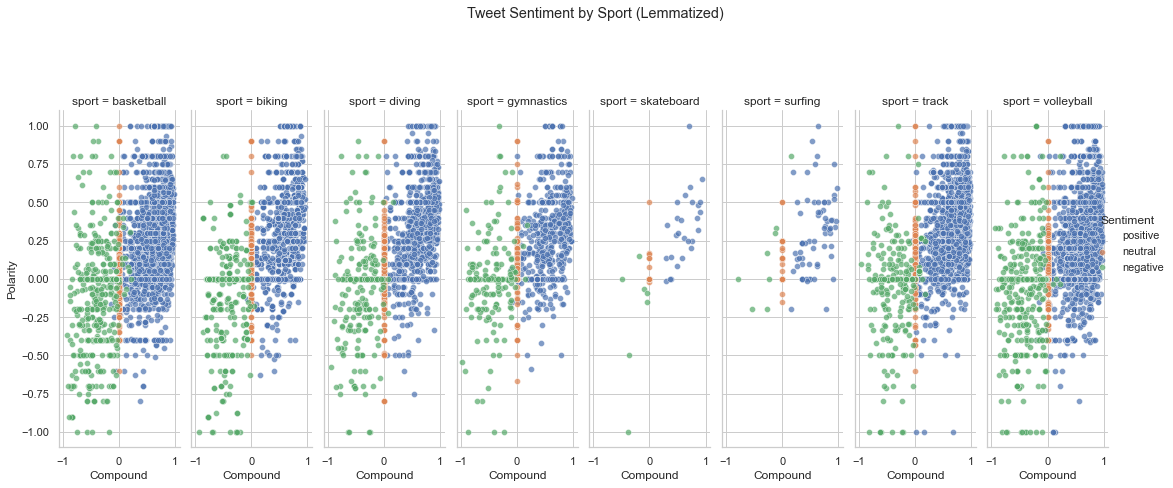

In [73]:
# Scatter plots for compound and polarity
sns.set_theme(style='whitegrid')

g = sns.FacetGrid(data=non_lemma_df, col='sport', hue='sentiment')
g.map(sns.scatterplot, 'compound', 'polarity', alpha=0.7)
g.add_legend(title='Sentiment')
g.set_axis_labels(x_var='Compound', y_var='Polarity')
g.fig.suptitle('Tweet Sentiment by Sport (Non-Lemmatized)')
plt.subplots_adjust(top=0.8)
g.fig.set_size_inches(16, 8)

g_l = sns.FacetGrid(data=lemma_df, col='sport', hue='lemma_sentiment')
g_l.map(sns.scatterplot, 'lemma_compound', 'lemma_polarity', alpha=0.7)
g_l.add_legend(title='Sentiment')
g_l.set_axis_labels(x_var='Compound', y_var='Polarity')
g_l.fig.suptitle('Tweet Sentiment by Sport (Lemmatized)')
plt.subplots_adjust(top=0.8)
g_l.fig.set_size_inches(16, 8)


Text(0, 0.5, 'Percentage')

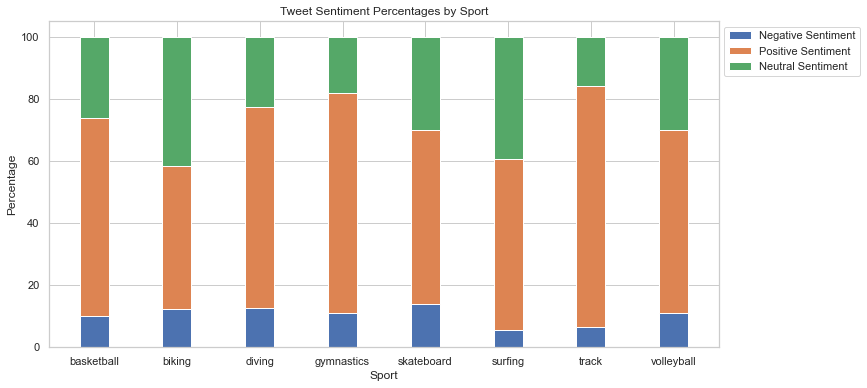

In [75]:
# Stacked Bar charts
sentiment_data = olympic_df[['id','sentiment', 'sport']]
df = pd.DataFrame(sentiment_data.groupby(by=['sport', 'sentiment'])['id'].count()).reset_index()

# get the list of counts for each sport by sentiment
neg = df.id[df.sentiment == 'negative'].values
pos = df.id[df.sentiment == 'positive'].values
neu = df.id[df.sentiment == 'neutral'].values

totals = [ i + j + k for i, j, k in zip(neg, pos, neu) ]
neg_adj = [ i / j * 100 for i, j in zip(neg, totals) ]
pos_adj = [ i / j * 100 for i, j in zip(pos, totals) ]
neu_adj = [ i / j * 100 for i, j in zip(neu, totals) ]

labels = list(olympic_df.sport.unique())

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(labels, neg_adj, width=0.35, label='Negative Sentiment')
ax.bar(labels, pos_adj, width=0.35, bottom=neg_adj, label='Positive Sentiment')
ax.bar(labels, neu_adj, width=0.35, bottom=[i + j for i,j in zip(neg_adj, pos_adj)], label='Neutral Sentiment')

plt.legend(loc='best', bbox_to_anchor=(1,1), ncol=1)
plt.title('Tweet Sentiment Percentages by Sport')
plt.xlabel('Sport')
plt.ylabel('Percentage')
